In [2]:
from huggingface_hub import notebook_login
import gc
from glob import glob
import torch
from datasets import load_dataset
from transformers import logging
from tqdm import tqdm
import pandas as pd
import numpy as np

logging.set_verbosity_info()


libgomp: Invalid value for environment variable OMP_NUM_THREADS


In [3]:
%load_ext autoreload
%autoreload 2

# Prepare data

In [ ]:
# from huggingface_hub import hf_hub_download

# dataset = hf_hub_download(repo_id="ai-lab/MBD", filename="ptls.tar.gz", repo_type="dataset", local_dir='./data/mbd')
# dataset = hf_hub_download(repo_id="ai-lab/MBD", filename="targets.tar.gz", repo_type="dataset", local_dir='./data/mbd')
# !tar -xvzf ./data/mbd/ptls.tar.gz ./data/mbd
# !tar -xvzf ./data/mbd/targets.tar.gz ./data/mbd

In [23]:
%%time

columns = ["client_id", 'event_time', 'event_type', 'amount', 'src_type32']
files = glob('./data/mbd/ptls/trx/fold=*/*', recursive=True)
data = pd.read_parquet(files, columns=columns)
len(data)

CPU times: user 28.8 s, sys: 11.3 s, total: 40.2 s
Wall time: 10.9 s


984490

In [24]:
data.shape

(984490, 5)

In [27]:
(984490 - 196845)/256*10

30767.3828125

In [28]:
984490 - 196845

787645

In [ ]:
epoch_size = len(data)

Percentile = 0.8235462141036987, 6.67263240814209
(3642893,)


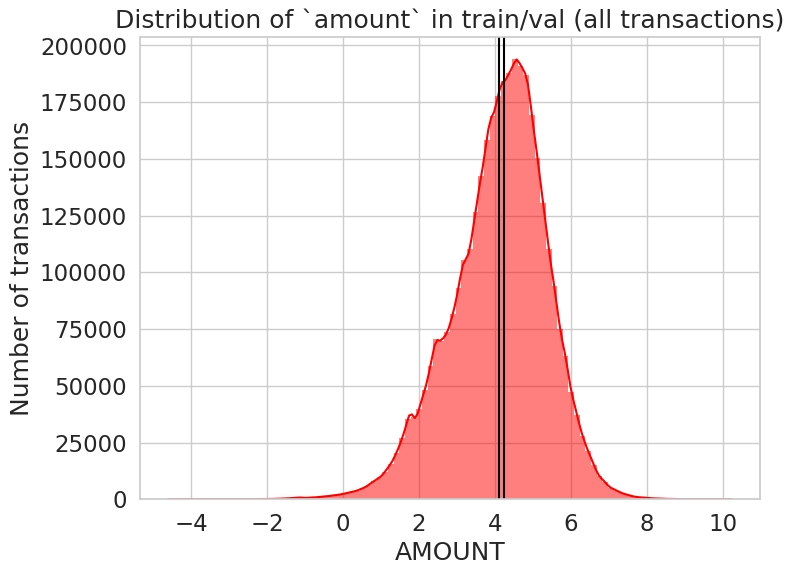

In [6]:
import seaborn as sns
from matplotlib import pyplot as plt

feature_name = 'amount'
sample = data.sample(10000)
amount = pd.Series(np.log10(np.concatenate(sample['amount'].values)))

q_l = amount.quantile(0.01)  # 95th percentile
q_h = amount.quantile(0.99)  # 95th percentile

print(f"Percentile = {q_l}, {q_h}")

print(amount.shape)


sns.set(rc={'figure.figsize':(8,6)})
sns.set_theme(style='whitegrid', font_scale=1.5)
sns.histplot(amount, color="red", label="Amount", bins=100, kde=True, linewidth=0)


#Adding a vertical line for
plt.axvline(np.mean(amount), color='black', label='Mean value')
plt.axvline(np.median(amount), color='black', label='Median value')


# Add labels
plt.title(f'Distribution of `{feature_name}` in train/val (all transactions)')
plt.ylabel('Number of transactions')
plt.xlabel(f'{feature_name.upper()}')
plt.show()

# Transactions to text

In [7]:
from datetime import datetime

def trx_to_text(trx, columns, max_len=256):
    
    client_id = trx['client_id']
    del trx['client_id']
    
    for k in columns:
        if k == "event_time":
            trx[k] = list(map(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d'), trx[k]))
        elif k == "amount":
            trx[k] = list(map(lambda x: f"{x:.2f}", np.log10(trx[k])))
                
    df = pd.DataFrame(trx).tail(max_len)
    
    return client_id, df.to_string(index=False)

In [ ]:
207618048/

In [8]:
import json

COLUMNS = ['event_time', 'event_type', 'amount', 'src_type32']
MAX_LEN = 256

# Test
fold = 4
data = pd.read_parquet(f'./data/mbd/ptls/trx/fold={fold}/', columns=columns).to_dict("records")
    
with open(f'./data/mbd/json/test/mbd_fold_{fold}.jsonl', 'w') as outfile:
    for trx in tqdm(data):
        client_id, text = trx_to_text(trx, columns=COLUMNS, max_len=MAX_LEN)
        entry = {'client_id': client_id, 'text': text}
        json.dump(entry, outfile)
        outfile.write('\n')

# Train
for fold in range(4):
    
    data = pd.read_parquet(f'./data/mbd/ptls/trx/fold={fold}/', columns=columns).to_dict("records")
    
    with open(f'./data/mbd/json/train/mbd_fold_{fold}.jsonl', 'w') as outfile:
        for trx in tqdm(data):
            client_id, text = trx_to_text(trx, columns=COLUMNS, max_len=MAX_LEN)
            entry = {'client_id': client_id, 'text': text}
            json.dump(entry, outfile)
            outfile.write('\n')

100%|██████████| 196902/196902 [11:16<00:00, 291.06it/s]


In [22]:
196845*5

984225

# Check number of tokens

In [13]:
data = pd.read_parquet(f'./data/mbd/ptls/trx/fold=4/', columns=columns).to_dict("records")

In [14]:
from transformers import LlamaTokenizer
name = 'small_models_run/gigar2-2b-450k-hf'
tokenizer = LlamaTokenizer.from_pretrained(name)

loading file tokenizer.model
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading file tokenizer.json


In [15]:
lens = []


COLUMNS = ['event_time', 'event_type', 'amount', 'src_type32']
MAX_LEN = 256


for trx in tqdm(data[:1000]):
    _, text = trx_to_text(trx.copy(), columns=COLUMNS, max_len=MAX_LEN)
    tokenized = tokenizer(text, padding="max_length", truncation=True)
    lens.append([len(trx['event_time']), len(tokenized['input_ids'])])

  0%|          | 0/1000 [00:00<?, ?it/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
100%|██████████| 1000/1000 [00:09<00:00, 104.28it/s]


In [16]:
df_lens = pd.DataFrame(lens, columns=['trx', 'tokens'])

In [17]:
df_lens.head()

,trx,tokens
0,706,5135
1,183,3675
2,221,4484
3,560,5140
4,974,5135


In [1]:
5135/706

7.2733711048158645

Tokens per trx: 22.191245882968317


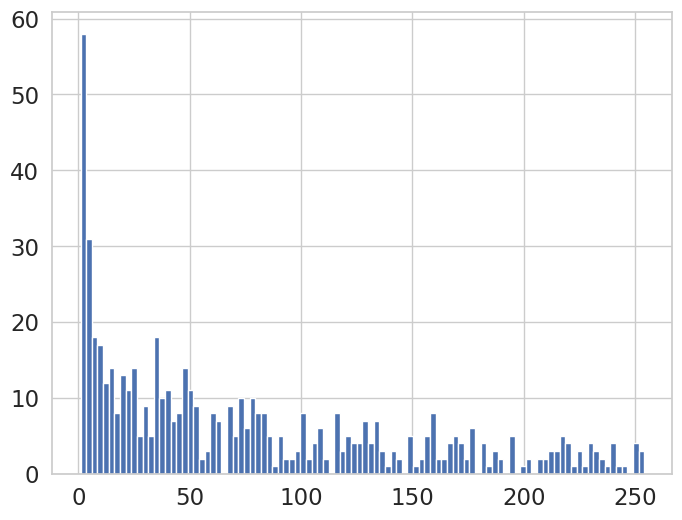

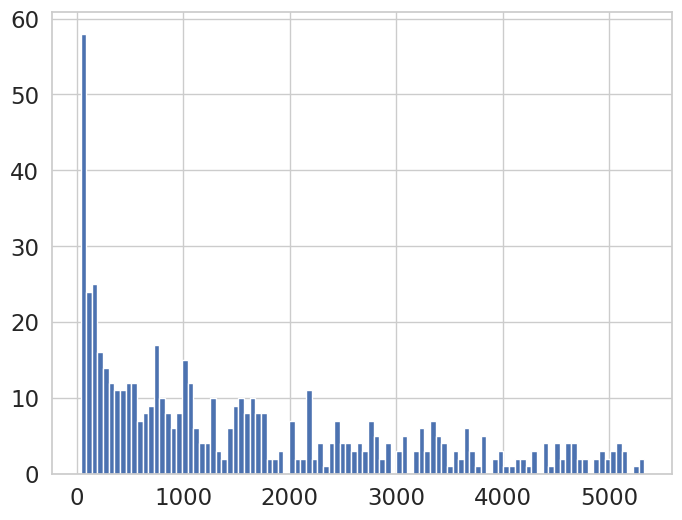

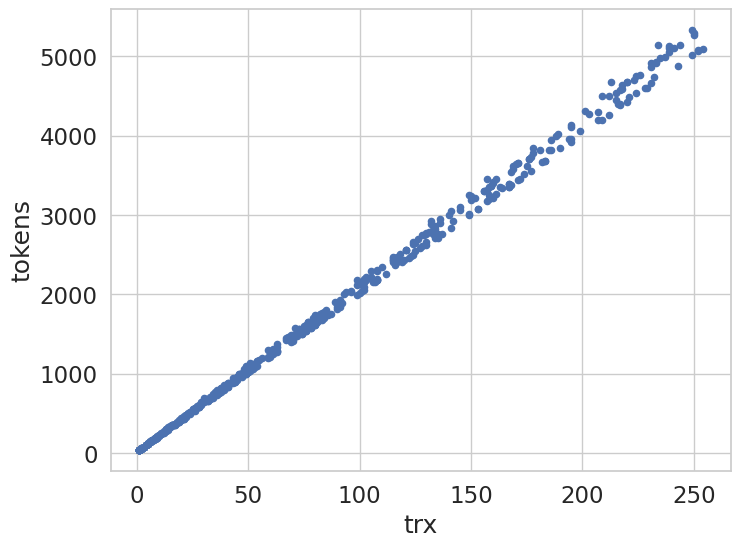

In [18]:
print('Tokens per trx:', np.mean(df_lens[df_lens.trx<MAX_LEN].tokens/df_lens[df_lens.trx<MAX_LEN].trx))
df_lens[df_lens.trx<MAX_LEN].trx.hist(bins=100)
plt.show()
df_lens[df_lens.trx<MAX_LEN].tokens.hist(bins=100)
plt.show()
df_lens[df_lens.trx<MAX_LEN].plot.scatter(x='trx', y='tokens')
plt.show()

In [19]:
print(text[:1008])

event_time  event_type amount  src_type32
2022-04-30           1   5.30          11
2022-04-30           1   5.96          11
2022-05-02           1   5.46          11
2022-05-03           1   5.41          11
2022-05-03           4   4.59          11
2022-05-03           2   4.56          11
2022-05-03           1   5.51          11
2022-05-03           2   4.14          11
2022-05-04          11   4.41          11
2022-05-05           2   4.52          11
2022-05-06           1   5.96          11
2022-05-06           4   4.76          11
2022-05-07           1   4.64          11
2022-05-07           4   4.73          11
2022-05-08           1   4.77          11
2022-05-09           4   3.74          11
2022-05-10           1   5.21          11
2022-05-11           4   4.81          11
2022-05-11           4   4.42          11
2022-05-11           1   5.73          11
2022-05-12           1   4.34          11
2022-05-12           1   5.86          11
2022-05-13           1   3.89     

In [8]:
1200000000/128/4096/2

1144.4091796875

In [9]:
4096*2

8192

# Balanced dataset

In [1]:
import pandas as pd
balanced_ids = pd.read_parquet('/home/jovyan/maorlov/ggcht/data/mbd/balanced/mbd_targets_balanced.parquet', columns=['client_id'])

In [2]:
balanced_ids.shape

(70532, 1)

In [3]:
ids = set(balanced_ids['client_id'])

In [4]:
from glob import glob
files = glob('/home/jovyan/maorlov/ggcht/data/mbd/ptls/trx/fold=*/*', recursive=True)
data = pd.read_parquet(files)

In [5]:
data.shape

(984490, 15)

In [6]:
data_balanced = data[data.client_id.isin(ids)]

In [7]:
data_balanced.shape

(69474, 15)

In [8]:
data_balanced.to_parquet('/home/jovyan/maorlov/ggcht/data/mbd/balanced/trx_balanced.parquet')

In [12]:
json_files = glob('/home/jovyan/maorlov/ggcht/data/mbd/json/train/*', recursive=True) + glob('/home/jovyan/maorlov/ggcht/data/mbd/json/test/*', recursive=True)
json_files  

['/home/jovyan/maorlov/ggcht/data/mbd/json/train/mbd_fold_0.jsonl',
 '/home/jovyan/maorlov/ggcht/data/mbd/json/train/mbd_fold_1.jsonl',
 '/home/jovyan/maorlov/ggcht/data/mbd/json/train/mbd_fold_2.jsonl',
 '/home/jovyan/maorlov/ggcht/data/mbd/json/train/mbd_fold_3.jsonl',
 '/home/jovyan/maorlov/ggcht/data/mbd/json/test/mbd_fold_4.jsonl']

In [19]:
import json
from tqdm import tqdm

json_data = []

for json_file in json_files:
    with open(json_file) as f:
        for line in tqdm(f):
            x = json.loads(line)
            if x['client_id'] in ids:
                json_data.append(x)
        
print(len(json_data))

196938it [00:04, 40958.32it/s]
196863it [00:04, 41279.54it/s]
196942it [00:04, 40576.84it/s]
196902it [00:04, 40033.86it/s]
196845it [00:03, 51584.65it/s]

984490


In [24]:
with open(f'/home/jovyan/maorlov/ggcht/data/mbd/balanced/json_balanced.jsonl', 'w') as outfile:
    for entry in tqdm(json_data):
        json.dump(entry, outfile)
        outfile.write('\n')

100%|██████████| 69474/69474 [00:01<00:00, 37131.59it/s]
